In [2]:
# Setup
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.special import softmax

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision')

# ------------------------------------------------------------------
# Paths
# ------------------------------------------------------------------
NO_PC_DIR = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/ret_full_nopc_withsex')
PC_DIR = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full')
ANCESTRY_PATH = Path('/Users/sarahurbut/aladynoulli2/ukb.kgp_projected.tsv')
PRS_PATH = Path('/Users/sarahurbut/aladynoulli2/pyScripts/prs_with_eid.csv')
PROCESSED_IDS_PATH = Path('/Users/sarahurbut/aladynoulli2/pyScripts/processed_patient_ids.npy')

# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------
def load_phi_batches(base_dir: Path, n_batches: int = 41):
    """Load phi tensors from batched checkpoints."""
    phi_list = []
    for batch_idx in range(n_batches):
        start = batch_idx * 10000
        end = (batch_idx + 1) * 10000
        ckpt = base_dir / f'enrollment_model_W0.0001_batch_{start}_{end}.pt'
        if ckpt.exists():
            ckpt_state = torch.load(ckpt, map_location='cpu')
            if 'model_state_dict' in ckpt_state and 'phi' in ckpt_state['model_state_dict']:
                phi_list.append(ckpt_state['model_state_dict']['phi'].cpu().numpy())
    if not phi_list:
        raise FileNotFoundError(f'No phi tensors found in {base_dir}')
    return np.mean(phi_list, axis=0), phi_list

# ------------------------------------------------------------------
# Load tensors/metadata
# ------------------------------------------------------------------
phi_no_pc_mean, phi_no_pc_list = load_phi_batches(NO_PC_DIR)
phi_pc_mean, phi_pc_list = load_phi_batches(PC_DIR)

thetas_nopcs = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_sex_nopcs_retrospective.pt', map_location='cpu')
if hasattr(thetas_nopcs, 'numpy'):
    thetas_nopcs = thetas_nopcs.numpy()

thetas_withpcs = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_pcs_retrospective.pt', map_location='cpu')
if hasattr(thetas_withpcs, 'numpy'):
    thetas_withpcs = thetas_withpcs.numpy()

ancestry_raw = pd.read_csv(ANCESTRY_PATH, sep='\t', usecols=['eid', 'rf80']).drop_duplicates('eid')
ancestry_raw['eid_numeric'] = pd.to_numeric(ancestry_raw['eid'], errors='coerce')
ancestry_df = ancestry_raw.dropna(subset=['eid_numeric']).assign(eid_numeric=lambda d: d['eid_numeric'].astype(int))

eid_to_ancestry = dict(zip(ancestry_df['eid_numeric'], ancestry_df['rf80']))
processed_ids = np.load(PROCESSED_IDS_PATH).astype(int)
ancestry_labels = np.array([eid_to_ancestry.get(int(eid), 'UNK') for eid in processed_ids[:len(thetas_withpcs)]])

prs_df = pd.read_csv(PRS_PATH)

print('✅ Setup complete')
print(f'   phi mean shape: {phi_no_pc_mean.shape}')
print(f'   theta shapes: no PC {thetas_nopcs.shape} | with PC {thetas_withpcs.shape}')
print(f'   ancestry matched: {(ancestry_labels != "UNK").sum():,} / {len(ancestry_labels):,}')
print(f'   PRS available: {len([c for c in prs_df.columns if c != "PatientID"])} scores')


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_61536/4234223572.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_state = torch.load(ckpt, map_location='

✅ Setup complete
   phi mean shape: (21, 348, 52)
   theta shapes: no PC (400000, 21, 52) | with PC (400000, 21, 52)
   ancestry matched: 400,000 / 400,000
   PRS available: 36 scores


In [3]:
# FH carriers: enrichment of pre-event rise in Signature 5
# Assumes you already have in memory:
# - processed_ids: np.array of eids (N,)
# - thetas_withpcs (or thetas_nopcs): shape [N, K=21, T]
# - Y: outcomes array shape [N, D, T]
# - event_indices: list/array of indices in Y that define the CAD/ASCVD composite
# - df with ancestry (optional): columns ['eid','rf80'] if you want to stratify later
import torch
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from statsmodels.stats.proportion import proportion_confint

# ----------------------------
# Inputs
# ----------------------------
fh_carrier_path = '/Users/sarahurbut/Downloads/out/ukb_exome_450k_fh.carrier.txt'  # ~ expanded here
Y = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt')
if hasattr(Y, 'detach'):
    Y = Y.detach().cpu().numpy()
print(f"Y shape: {Y.shape}")
event_indices = [112, 113, 114, 115, 116]

thetas_withpcs = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_pcs_retrospective.pt', map_location='cpu')
if hasattr(thetas_withpcs, 'numpy'):
    thetas_withpcs = thetas_withpcs.numpy()
theta = thetas_withpcs   # choose which set to test
sig_idx = 5              # Signature 5 (0-based index)
pre_window = 5           # years/timepoints to look back before event
epsilon = 0.0            # >0 means strict rise; use small value like 0.002 to be conservative

# ----------------------------
# Load and align FH carriers
# ----------------------------
fh = pd.read_csv(fh_carrier_path, sep='\t', dtype={'IID': int}, low_memory=False)
# Robustly pick eid column
if 'IID' not in fh.columns:
    cand = [c for c in fh.columns if c.lower() in ('eid','id','ukb_eid','participant_id')]
    assert len(cand) > 0, f"No EID column found in {fh_carrier_path}"
    fh = fh.rename(columns={cand[0]: 'eid'})

fh_carriers = fh[['IID']].drop_duplicates()
eid_to_carrier = set(fh_carriers['IID'].astype(int).tolist())

eids = processed_ids.astype(int)
is_carrier = np.isin(eids, list(eid_to_carrier))  # [N]

# ----------------------------
# Build event flags and first event time
# ----------------------------
def to_numpy(x):
    import torch
    return x.detach().cpu().numpy() if 'torch' in str(type(x)) else x

Y_np = to_numpy(Y[:400000,])                     # [N, D, T]
ev_idx = np.array(event_indices, int)
N, K, T = theta.shape

# first event time index per person (min t where any selected event =1)
Y_sel = (Y_np[:, ev_idx, :] > 0)       # [N, |ev|, T]
has_event = Y_sel.any(axis=(1, 2))     # [N]
first_event_t = np.full(N, -1, dtype=int)
# Find first time index with any event
any_event_over_ev = Y_sel.any(axis=1)  # [N, T]
first_event_t[has_event] = np.argmax(any_event_over_ev[has_event], axis=1)

# ----------------------------
# Compute pre-event rise in Signature 5
# ----------------------------
valid = (has_event) & (first_event_t >= pre_window)  # need enough history
idx_valid = np.where(valid)[0]

sig = theta[:, sig_idx, :]  # [N, T]
pre_start = first_event_t[idx_valid] - pre_window
pre_end = first_event_t[idx_valid] - 1

# delta over window (end - start)
delta = sig[idx_valid, pre_end] - sig[idx_valid, pre_start]  # [n_valid]
is_rise = (delta > epsilon)

# Partition by carrier status
car_valid = is_carrier[idx_valid]
rise_car = is_rise[car_valid]
rise_non = is_rise[~car_valid]

n_car = rise_car.size
n_non = rise_non.size
ev_car = int(rise_car.sum())
ev_non = int(rise_non.sum())

# 2x2 table: rows = carrier vs noncarrier, cols = rise vs no-rise
table = [[ev_car, n_car - ev_car],
         [ev_non, n_non - ev_non]]
OR, p = fisher_exact(table, alternative='greater')

# Proportion CIs
car_ci = proportion_confint(ev_car, n_car, method='wilson') if n_car > 0 else (np.nan, np.nan)
non_ci = proportion_confint(ev_non, n_non, method='wilson') if n_non > 0 else (np.nan, np.nan)

print("\n=== FH carriers: enrichment of pre-event Signature 5 rise ===")
print(f"Window: last {pre_window} years before first event; epsilon={epsilon}")
print(f"Valid N with event & sufficient history: {idx_valid.size}")
print(f"Carriers:   {ev_car}/{n_car} rising  (prop={ev_car/max(n_car,1):.3f}, CI95={car_ci})")
print(f"Noncarriers:{ev_non}/{n_non} rising  (prop={ev_non/max(n_non,1):.3f}, CI95={non_ci})")
print(f"Fisher exact (greater) OR={OR:.3f}, p={p:.3e}")

# Optional: stratify by ancestry to check robustness
try:
    from collections import defaultdict
    # df_anc must exist: columns ['eid','rf80']
    anc_map = dict(zip(df['eid'].astype(int), df['rf80']))
    by_anc = defaultdict(list)
    for i, v in zip(idx_valid, is_rise[idx_valid]):
        anc = anc_map.get(int(eids[i]), 'UNK')
        by_anc[anc].append((is_carrier[i], bool(v)))
    print("\nPer-ancestry quick summary (carriers rising / carriers total | noncarriers rising / noncarriers total):")
    for anc, lst in by_anc.items():
        c_rise = sum(v for c, v in lst if c)
        c_tot = sum(1 for c, _ in lst if c)
        n_rise = sum(v for c, v in lst if not c)
        n_tot = sum(1 for c, _ in lst if not c)
        if c_tot + n_tot >= 50:  # suppress tiny strata
            print(f"  {anc}: {c_rise}/{c_tot} | {n_rise}/{n_tot}")
except Exception:
    pass

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_61536/2515953415.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load('/Users/sarahurbut/Library/Cl

Y shape: (407878, 348, 52)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_61536/2515953415.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thetas_withpcs = torch.load('/Users/sarahurb


=== FH carriers: enrichment of pre-event Signature 5 rise ===
Window: last 5 years before first event; epsilon=0.0
Valid N with event & sufficient history: 56308
Carriers:   445/464 rising  (prop=0.959, CI95=(0.9369339508946029, 0.9736309252363722))
Noncarriers:52208/55844 rising  (prop=0.935, CI95=(0.9328137149837256, 0.9369065594482678))
Fisher exact (greater) OR=1.631, p=1.746e-02


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_61536/79125235.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


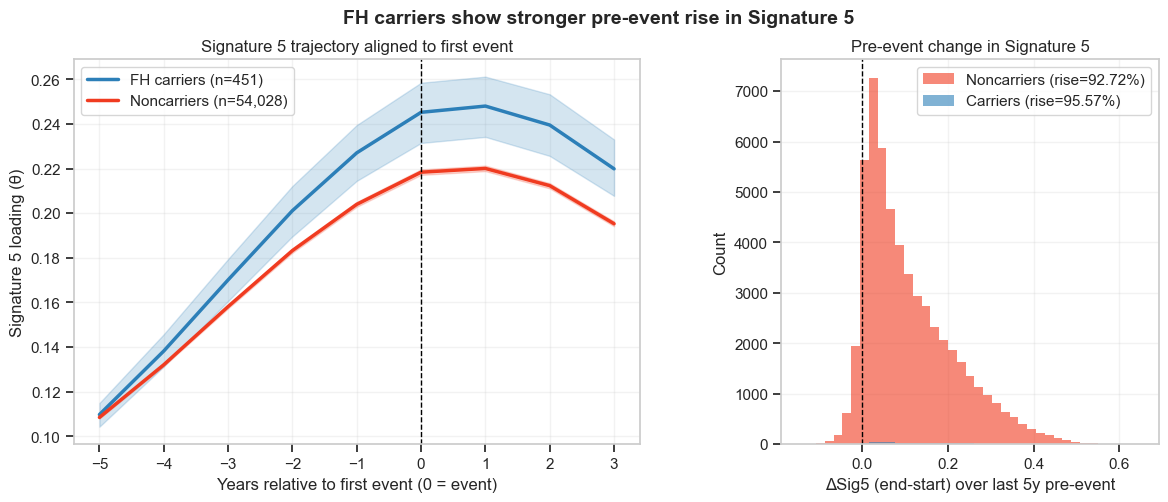

In [4]:
# Build event-aligned windows

# Visualization: FH carriers vs noncarriers — Signature 5 rise before event
# Panels:
#  (A) Event-aligned mean trajectory of Sig 5 (carriers vs noncarriers) with 95% CI
#  (B) Distribution of pre-event ΔSig5 (end-start over last 5y) + proportion rising

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

# Inputs already in memory:
# - processed_ids (N,), is_carrier (N bool), thetas_withpcs or thetas_nopcs as `theta` [N,K,T]
# - Y [N,D,T], event_indices (list/array)
# - Choose which theta to plot:
theta = thetas_withpcs
sig_idx = 5
pre_window = 5
post_window = 3  # for plotting after event
min_hist = pre_window  # need at least this much history

def to_numpy(x):
    import torch
    return x.detach().cpu().numpy() if 'torch' in str(type(x)) else x


N, K, T = theta.shape
ev_idx = np.array(event_indices, int)

# First event time per person
Y_sel = (Y_np[:, ev_idx, :] > 0)               # [N, |ev|, T]
has_event = Y_sel.any(axis=(1, 2))
any_ev_time = Y_sel.any(axis=1)                # [N, T]
first_ev_t = np.full(N, -1, int)
first_ev_t[has_event] = np.argmax(any_ev_time[has_event], axis=1)



sig = theta[:, sig_idx, :]                     # [N, T]
aligned_span = np.arange(-pre_window, post_window + 1)  # e.g., -5..+3
L = len(aligned_span)

def build_aligned(sig, first_t, mask):
    idx = np.where(mask & (first_t >= pre_window) & (first_t < T - post_window))[0]
    aligned = np.empty((len(idx), L), float); aligned[:] = np.nan
    for j, i in enumerate(idx):
        t0 = first_t[i]
        aligned[j] = sig[i, t0 - pre_window : t0 + post_window + 1]
    return idx, aligned

idx_car, aligned_car = build_aligned(sig, first_ev_t, is_carrier)
idx_non, aligned_non = build_aligned(sig, first_ev_t, ~is_carrier)

# Pre-event delta distributions (last 5y: end-start)
delta_car = aligned_car[:, pre_window] - aligned_car[:, 0]
delta_non = aligned_non[:, pre_window] - aligned_non[:, 0]
rise_car = (delta_car > 0).mean()
rise_non = (delta_non > 0).mean()

# Mean and 95% bootstrap CI for trajectories
def mean_ci(a, n_boot=2000, alpha=0.05):
    m = np.nanmean(a, axis=0)
    # bootstrap along rows, ignore NaNs via masking per timepoint
    ci_low, ci_high = [], []
    rng = np.random.default_rng(42)
    for t in range(a.shape[1]):
        col = a[:, t]
        col = col[~np.isnan(col)]
        if len(col) < 10:
            ci_low.append(np.nan); ci_high.append(np.nan); continue
        res = bootstrap((col,), np.mean, vectorized=False, n_resamples=n_boot,
                        paired=False, confidence_level=1-alpha, random_state=rng, method='basic')
        ci_low.append(res.confidence_interval.low)
        ci_high.append(res.confidence_interval.high)
    return m, np.array(ci_low), np.array(ci_high)

m_car, lo_car, hi_car = mean_ci(aligned_car)
m_non, lo_non, hi_non = mean_ci(aligned_non)

# Plot
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 2], wspace=0.3)

# (A) Event-aligned mean trajectories
ax1 = fig.add_subplot(gs[0, 0])
x = aligned_span
ax1.plot(x, m_car, color='#2c7fb8', lw=2.5, label=f'FH carriers (n={aligned_car.shape[0]:,})')
ax1.fill_between(x, lo_car, hi_car, color='#2c7fb8', alpha=0.2)
ax1.plot(x, m_non, color='#f03b20', lw=2.5, label=f'Noncarriers (n={aligned_non.shape[0]:,})')
ax1.fill_between(x, lo_non, hi_non, color='#f03b20', alpha=0.2)
ax1.axvline(0, color='k', ls='--', lw=1)
ax1.set_xlabel('Years relative to first event (0 = event)')
ax1.set_ylabel('Signature 5 loading (θ)')
ax1.set_title('Signature 5 trajectory aligned to first event')
ax1.grid(True, alpha=0.25)
ax1.legend(frameon=True)

# (B) Δ over last 5y before event
ax2 = fig.add_subplot(gs[0, 1])
bins = np.linspace(min(delta_car.min(), delta_non.min()),
                   max(delta_car.max(), delta_non.max()), 40)
ax2.hist(delta_non, bins=bins, alpha=0.6, color='#f03b20', label=f'Noncarriers (rise={rise_non:.2%})')
ax2.hist(delta_car, bins=bins, alpha=0.6, color='#2c7fb8', label=f'Carriers (rise={rise_car:.2%})')
ax2.axvline(0, color='k', ls='--', lw=1)
ax2.set_xlabel('ΔSig5 (end-start) over last 5y pre-event')
ax2.set_ylabel('Count')
ax2.set_title('Pre-event change in Signature 5')
ax2.grid(True, alpha=0.25)
ax2.legend(frameon=True)

fig.suptitle('FH carriers show stronger pre-event rise in Signature 5', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## look at relatie to general population

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
df_cov = pd.read_csv(
    "/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv"
)
df_cov = df_cov.set_index("identifier")          # now rows are keyed by eid

baseline_age = df_cov.loc[processed_ids, "age"].to_numpy()# 
age_baseline = df_cov.loc[processed_ids, "age"].to_numpy()# 

In [34]:
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/reference_trajectories.pt')
signature_refs = refs["signature_refs"]
signature_refs.shape

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_81805/3749750633.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library/

torch.Size([20, 52])

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_15014/2109819222.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library

Scale check:
  theta range: [0.0000, 0.9868]
  sig_refs_from_theta[5] range: [0.0030, 0.0791]
  theta_centered range: [-0.0718, 0.9336]
  theta_centered mean: 0.0000 (should be ~0)
  theta_centered median: -0.0029


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_15014/2109819222.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


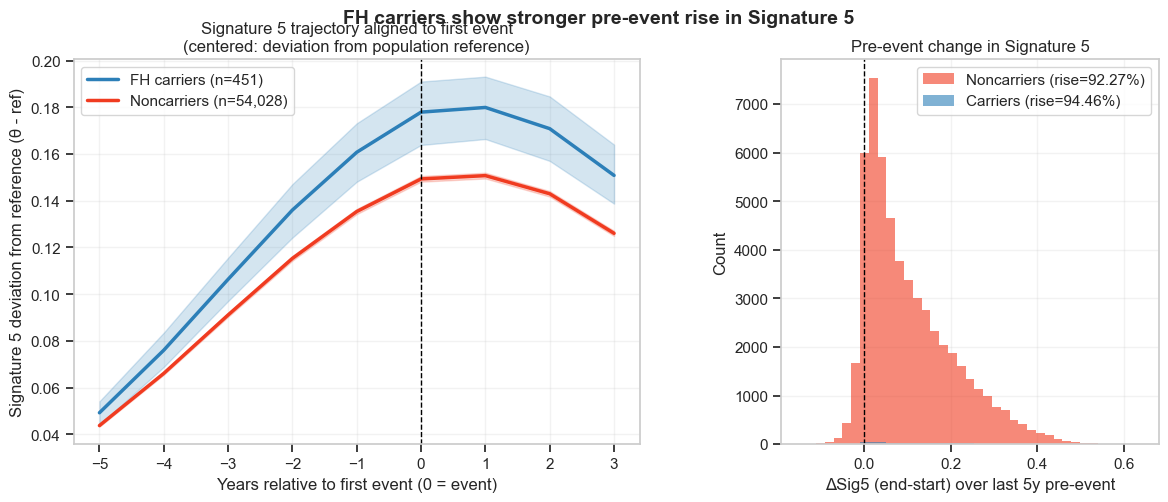

In [10]:
# Build event-aligned windows

# Visualization: FH carriers vs noncarriers — Signature 5 rise before event
# Panels:
#  (A) Event-aligned mean trajectory of Sig 5 (carriers vs noncarriers) with 95% CI
#  (B) Distribution of pre-event ΔSig5 (end-start over last 5y) + proportion rising

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import bootstrap

# Inputs already in memory:
# - processed_ids (N,), is_carrier (N bool), thetas_withpcs or thetas_nopcs as `theta` [N,K,T]
# - Y [N,D,T], event_indices (list/array)
# - Choose which theta to plot:
theta = thetas_withpcs
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/reference_trajectories.pt')
signature_refs = refs["signature_refs"]
signature_refs = np.asarray(signature_refs)

K_ref = signature_refs.shape[0]  # Number of reference signatures (should be 20)

# Calculate reference trajectories as mean across patients (same scale as theta: 0-1)
sig_refs_from_theta = np.mean(theta[:, :K_ref, :], axis=0)  # [K, T] - mean across patients

theta_centered = theta.copy()
theta_centered[:, :K_ref, :] -= sig_refs_from_theta[None, :, :]   # subtract population mean
# healthy component, if present, is left untouched
# use theta_centered from here on

# Diagnostic: Check the scale of values
print("Scale check:")
print(f"  theta range: [{theta[:, sig_idx, :].min():.4f}, {theta[:, sig_idx, :].max():.4f}]")
print(f"  sig_refs_from_theta[{sig_idx}] range: [{sig_refs_from_theta[sig_idx, :].min():.4f}, {sig_refs_from_theta[sig_idx, :].max():.4f}]")
print(f"  theta_centered range: [{theta_centered[:, sig_idx, :].min():.4f}, {theta_centered[:, sig_idx, :].max():.4f}]")
print(f"  theta_centered mean: {theta_centered[:, sig_idx, :].mean():.4f} (should be ~0)")
print(f"  theta_centered median: {np.nanmedian(theta_centered[:, sig_idx, :]):.4f}")

sig_idx = 5
pre_window = 5
post_window = 3  # for plotting after event
min_hist = pre_window  # need at least this much history

def to_numpy(x):
    import torch
    return x.detach().cpu().numpy() if 'torch' in str(type(x)) else x


N, K, T = theta.shape
ev_idx = np.array(event_indices, int)

# First event time per person
Y_sel = (Y_np[:, ev_idx, :] > 0)               # [N, |ev|, T]
has_event = Y_sel.any(axis=(1, 2))
any_ev_time = Y_sel.any(axis=1)                # [N, T]
first_ev_t = np.full(N, -1, int)
first_ev_t[has_event] = np.argmax(any_ev_time[has_event], axis=1)



sig = theta_centered[:, sig_idx, :]
                   # [N, T]
aligned_span = np.arange(-pre_window, post_window + 1)  # e.g., -5..+3
L = len(aligned_span)

def build_aligned(sig, first_t, mask):
    idx = np.where(mask & (first_t >= pre_window) & (first_t < T - post_window))[0]
    aligned = np.empty((len(idx), L), float); aligned[:] = np.nan
    for j, i in enumerate(idx):
        t0 = first_t[i]
        aligned[j] = sig[i, t0 - pre_window : t0 + post_window + 1]
    return idx, aligned

idx_car, aligned_car = build_aligned(sig, first_ev_t, is_carrier)
idx_non, aligned_non = build_aligned(sig, first_ev_t, ~is_carrier)

# Pre-event delta distributions (last 5y: end-start)
delta_car = aligned_car[:, pre_window] - aligned_car[:, 0]
delta_non = aligned_non[:, pre_window] - aligned_non[:, 0]
rise_car = (delta_car > 0).mean()
rise_non = (delta_non > 0).mean()

# Mean and 95% bootstrap CI for trajectories
def mean_ci(a, n_boot=2000, alpha=0.05):
    m = np.nanmean(a, axis=0)
    # bootstrap along rows, ignore NaNs via masking per timepoint
    ci_low, ci_high = [], []
    rng = np.random.default_rng(42)
    for t in range(a.shape[1]):
        col = a[:, t]
        col = col[~np.isnan(col)]
        if len(col) < 10:
            ci_low.append(np.nan); ci_high.append(np.nan); continue
        res = bootstrap((col,), np.mean, vectorized=False, n_resamples=n_boot,
                        paired=False, confidence_level=1-alpha, random_state=rng, method='basic')
        ci_low.append(res.confidence_interval.low)
        ci_high.append(res.confidence_interval.high)
    return m, np.array(ci_low), np.array(ci_high)

m_car, lo_car, hi_car = mean_ci(aligned_car)
m_non, lo_non, hi_non = mean_ci(aligned_non)

# Plot
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 2], wspace=0.3)

# (A) Event-aligned mean trajectories
ax1 = fig.add_subplot(gs[0, 0])
x = aligned_span
ax1.plot(x, m_car, color='#2c7fb8', lw=2.5, label=f'FH carriers (n={aligned_car.shape[0]:,})')
ax1.fill_between(x, lo_car, hi_car, color='#2c7fb8', alpha=0.2)
ax1.plot(x, m_non, color='#f03b20', lw=2.5, label=f'Noncarriers (n={aligned_non.shape[0]:,})')
ax1.fill_between(x, lo_non, hi_non, color='#f03b20', alpha=0.2)
ax1.axvline(0, color='k', ls='--', lw=1)
ax1.set_xlabel('Years relative to first event (0 = event)')
ax1.set_ylabel('Signature 5 deviation from reference (θ - ref)')
ax1.set_title('Signature 5 trajectory aligned to first event\n(centered: deviation from population reference)')
ax1.grid(True, alpha=0.25)
ax1.legend(frameon=True)

# (B) Δ over last 5y before event
ax2 = fig.add_subplot(gs[0, 1])
bins = np.linspace(min(delta_car.min(), delta_non.min()),
                   max(delta_car.max(), delta_non.max()), 40)
ax2.hist(delta_non, bins=bins, alpha=0.6, color='#f03b20', label=f'Noncarriers (rise={rise_non:.2%})')
ax2.hist(delta_car, bins=bins, alpha=0.6, color='#2c7fb8', label=f'Carriers (rise={rise_car:.2%})')
ax2.axvline(0, color='k', ls='--', lw=1)
ax2.set_xlabel('ΔSig5 (end-start) over last 5y pre-event')
ax2.set_ylabel('Count')
ax2.set_title('Pre-event change in Signature 5')
ax2.grid(True, alpha=0.25)
ax2.legend(frameon=True)

fig.suptitle('FH carriers show stronger pre-event rise in Signature 5', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
# What does Signature 5 learn about FH carriers beyond PRS?
# Hypothesis: Model learns (1) age at event, (2) CAD prevalence patterns, 
#             (3) temporal trajectory shape that PRS doesn't capture

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind

disease_names=pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/disease_names.csv')['x']
initial_clusters=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')
# Load PRS if available
try:
    prs_df = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/prs_with_eid.csv')
    prs_available = True
    print("✓ PRS data loaded")
except:
    prs_available = False
    print("⚠ PRS data not available")

# Get baseline age (from Cell 4)
try:
    df_cov = pd.read_csv("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv")
    df_cov = df_cov.set_index("identifier")
    age_baseline = df_cov.loc[processed_ids, "age"].to_numpy()
    print(f"✓ Baseline age loaded: {len(age_baseline)} patients")
except:
    print("⚠ Baseline age not available")
    age_baseline = None

# Use data from previous cells
Y_np = to_numpy(Y[:400000,])
ev_idx = np.array(event_indices, int)
theta = thetas_withpcs
sig_idx = 5

# Compute event times and ages
Y_sel = (Y_np[:, ev_idx, :] > 0)
has_event = Y_sel.any(axis=(1, 2))
any_ev_time = Y_sel.any(axis=1)
first_ev_t = np.full(len(has_event), -1, int)
first_ev_t[has_event] = np.argmax(any_ev_time[has_event], axis=1)

# Convert time index to age at event (assuming time index = age - 30)
age_at_event = np.full(len(has_event), np.nan)
age_at_event[has_event] = 30 + first_ev_t[has_event]

# Subset to those with events and sufficient history for analysis
valid = has_event & (first_ev_t >= 5) & (first_ev_t < 52)
idx_valid = np.where(valid)[0]

# Get carrier status for valid subset
carrier_valid = is_carrier[idx_valid]
noncarrier_valid = ~is_carrier[idx_valid]

print(f"\n{'='*80}")
print("WHAT DOES SIGNATURE 5 LEARN ABOUT FH CARRIERS BEYOND PRS?")
print(f"{'='*80}\n")

# ============================================================================
# 1. AGE AT EVENT: Do FH carriers have earlier events?
# ============================================================================
print("1. AGE AT EVENT COMPARISON")
print("-" * 80)

age_car = age_at_event[idx_valid[carrier_valid]]
age_non = age_at_event[idx_valid[noncarrier_valid]]

print(f"FH carriers with event:   n={len(age_car)}, median age={np.nanmedian(age_car):.1f} years")
print(f"Non-carriers with event:  n={len(age_non)}, median age={np.nanmedian(age_non):.1f} years")

# Statistical test
stat, p_age = mannwhitneyu(age_car, age_non, alternative='less')
print(f"Mann-Whitney U test (carriers < noncarriers): p={p_age:.4f}")

age_diff = np.nanmedian(age_car) - np.nanmedian(age_non)
print(f"Median age difference: {age_diff:.1f} years (carriers {'earlier' if age_diff < 0 else 'later'})")

# ============================================================================
# 2. CAD PREVALENCE: Do FH carriers have higher event rates?
# ============================================================================
print(f"\n2. CAD PREVALENCE COMPARISON")
print("-" * 80)

# Overall prevalence
prev_car = carrier_valid.sum() / len(idx_valid) if len(idx_valid) > 0 else 0
prev_non = noncarrier_valid.sum() / len(idx_valid) if len(idx_valid) > 0 else 0

# But we need to compare prevalence in the full population, not just those with events
# Get prevalence in full dataset
n_car_total = is_carrier.sum()
n_non_total = (~is_carrier).sum()
n_car_events = is_carrier[has_event].sum()
n_non_events = (~is_carrier)[has_event].sum()

event_rate_car = n_car_events / n_car_total if n_car_total > 0 else 0
event_rate_non = n_non_events / n_non_total if n_non_total > 0 else 0

print(f"FH carriers:   {n_car_events:,}/{n_car_total:,} with event ({event_rate_car*100:.2f}%)")
print(f"Non-carriers:  {n_non_events:,}/{n_non_total:,} with event ({event_rate_non*100:.2f}%)")

# Fisher's exact test
from scipy.stats import fisher_exact
table_prev = [[n_car_events, n_car_total - n_car_events],
               [n_non_events, n_non_total - n_non_events]]
OR_prev, p_prev = fisher_exact(table_prev, alternative='greater')
print(f"Fisher's exact test: OR={OR_prev:.3f}, p={p_prev:.4e}")

# ============================================================================
# 3. SIGNATURE 5 TRAJECTORY: Baseline levels and trajectory shape
# ============================================================================
print(f"\n3. SIGNATURE 5 TRAJECTORY ANALYSIS")
print("-" * 80)

sig = theta[:, sig_idx, :]  # [N, T]

# For those with events, get signature levels at different timepoints
# Baseline: 5 years before event
# Pre-event: 1 year before event
# At event: time of event

baseline_t = first_ev_t[idx_valid] - 5
pre_event_t = first_ev_t[idx_valid] - 1
event_t = first_ev_t[idx_valid]

# Get signature values
sig_baseline = sig[idx_valid, baseline_t]
sig_pre_event = sig[idx_valid, pre_event_t]
sig_at_event = sig[idx_valid, event_t]

# Compare carriers vs non-carriers
sig_baseline_car = sig_baseline[carrier_valid]
sig_baseline_non = sig_baseline[noncarrier_valid]

sig_pre_event_car = sig_pre_event[carrier_valid]
sig_pre_event_non = sig_pre_event[noncarrier_valid]

sig_at_event_car = sig_at_event[carrier_valid]
sig_at_event_non = sig_at_event[noncarrier_valid]

print(f"Baseline (5y before event):")
print(f"  Carriers:   median={np.nanmedian(sig_baseline_car):.4f}, mean={np.nanmean(sig_baseline_car):.4f}")
print(f"  Noncarriers: median={np.nanmedian(sig_baseline_non):.4f}, mean={np.nanmean(sig_baseline_non):.4f}")
stat, p_base = mannwhitneyu(sig_baseline_car, sig_baseline_non, alternative='two-sided')
print(f"  Mann-Whitney U: p={p_base:.4f}")

print(f"\nPre-event (1y before event):")
print(f"  Carriers:   median={np.nanmedian(sig_pre_event_car):.4f}, mean={np.nanmean(sig_pre_event_car):.4f}")
print(f"  Noncarriers: median={np.nanmedian(sig_pre_event_non):.4f}, mean={np.nanmean(sig_pre_event_non):.4f}")
stat, p_pre = mannwhitneyu(sig_pre_event_car, sig_pre_event_non, alternative='two-sided')
print(f"  Mann-Whitney U: p={p_pre:.4f}")

# Trajectory slope (rise rate)
slope_car = sig_pre_event_car - sig_baseline_car
slope_non = sig_pre_event_non - sig_baseline_non
print(f"\nTrajectory slope (pre-event - baseline, over 4 years):")
print(f"  Carriers:   median={np.nanmedian(slope_car):.4f}, mean={np.nanmean(slope_car):.4f}")
print(f"  Noncarriers: median={np.nanmedian(slope_non):.4f}, mean={np.nanmean(slope_non):.4f}")
stat, p_slope = mannwhitneyu(slope_car, slope_non, alternative='greater')
print(f"  Mann-Whitney U (carriers > noncarriers): p={p_slope:.4f}")

# ============================================================================
# 3b. PRECURSOR DISEASES: Which precursors are enriched in FH carriers?
# ============================================================================
print(f"\n3b. PRECURSOR DISEASE ANALYSIS")
print("-" * 80)

# Identify precursor diseases (those that typically precede CAD/ASCVD)
# Common precursors: hypertension, diabetes, hyperlipidemia, etc.
# We'll look at diseases that occur BEFORE the first CAD event

# Get precursor prevalence in FH carriers vs non-carriers
# Precursor: disease that occurs at any time BEFORE first_ev_t
precursor_results = []

for d in range(Y_np.shape[1]):
    disease_name = disease_names.iloc[d] if d < len(disease_names) else f"Disease_{d}"
    
    # Skip if this is one of the CAD event diseases
    if d in ev_idx:
        continue
    
    # For those with CAD events, check if they had this disease before the event
    # For those without CAD events, check if they ever had this disease
    
    # Carriers with CAD events
    car_with_event = is_carrier & has_event
    car_with_event_valid = car_with_event & (first_ev_t >= 0)
    
    if car_with_event_valid.sum() > 0:
        car_precursors = []
        for i in np.where(car_with_event_valid)[0]:
            ev_t = first_ev_t[i]
            # Check if disease d occurred before the CAD event
            if ev_t > 0:
                had_precursor = (Y_np[i, d, :ev_t] > 0).any()
            else:
                had_precursor = False
            car_precursors.append(had_precursor)
        car_precursor_rate = np.mean(car_precursors) if len(car_precursors) > 0 else 0
        car_precursor_n = len(car_precursors)
    else:
        car_precursor_rate = 0
        car_precursor_n = 0
    
    # Non-carriers with CAD events
    non_with_event = ~is_carrier & has_event
    non_with_event_valid = non_with_event & (first_ev_t >= 0)
    
    if non_with_event_valid.sum() > 0:
        non_precursors = []
        for i in np.where(non_with_event_valid)[0]:
            ev_t = first_ev_t[i]
            if ev_t > 0:
                had_precursor = (Y_np[i, d, :ev_t] > 0).any()
            else:
                had_precursor = False
            non_precursors.append(had_precursor)
        non_precursor_rate = np.mean(non_precursors) if len(non_precursors) > 0 else 0
        non_precursor_n = len(non_precursors)
    else:
        non_precursor_rate = 0
        non_precursor_n = 0
    
    # Fisher's exact test
    if car_precursor_n > 10 and non_precursor_n > 10:
        car_precursor_count = int(car_precursor_rate * car_precursor_n)
        non_precursor_count = int(non_precursor_rate * non_precursor_n)
        
        table_prec = [[car_precursor_count, car_precursor_n - car_precursor_count],
                      [non_precursor_count, non_precursor_n - non_precursor_count]]
        OR_prec, p_prec = fisher_exact(table_prec, alternative='two-sided')
        
        # Only keep if significant or high OR
        if p_prec < 0.05 or OR_prec > 1.5 or OR_prec < 0.67:
            precursor_results.append({
                'disease_idx': d,
                'disease_name': disease_name,
                'carrier_rate': car_precursor_rate,
                'carrier_n': car_precursor_n,
                'noncarrier_rate': non_precursor_rate,
                'noncarrier_n': non_precursor_n,
                'OR': OR_prec,
                'p': p_prec
            })

# Sort by OR (highest enrichment first)
precursor_results = sorted(precursor_results, key=lambda x: x['OR'], reverse=True)

# Initialize for summary (in case no results)
precursor_sig5 = []
precursor_not_sig5 = []

# Identify Signature 5 cluster diseases
if hasattr(initial_clusters, 'numpy'):
    initial_clusters_np = initial_clusters.numpy()
elif hasattr(initial_clusters, 'detach'):
    initial_clusters_np = initial_clusters.detach().cpu().numpy()
else:
    initial_clusters_np = np.array(initial_clusters)

# Find which cluster Signature 5 diseases belong to
# We need to identify a representative disease for Sig 5 - typically CAD-related diseases
# Use the CAD event diseases to identify the cluster
sig5_cluster_id = None
if len(ev_idx) > 0:
    # Most CAD event diseases should be in the same cluster
    cluster_ids_for_cad = initial_clusters_np[ev_idx]
    # Get the most common cluster (this should be Signature 5's cluster)
    unique, counts = np.unique(cluster_ids_for_cad, return_counts=True)
    sig5_cluster_id = unique[np.argmax(counts)]
    print(f"Signature 5 cluster ID: {sig5_cluster_id} (identified from CAD event diseases)")

# Get all diseases in Signature 5's cluster
sig5_cluster_diseases = np.where(initial_clusters_np == sig5_cluster_id)[0]
print(f"Total diseases in Signature 5 cluster: {len(sig5_cluster_diseases)}")

# Exclude CAD event diseases from precursor list (they're outcomes, not precursors)
sig5_precursor_diseases = [d for d in sig5_cluster_diseases if d not in ev_idx]
print(f"Signature 5 precursor diseases (excluding CAD events): {len(sig5_precursor_diseases)}")

# Check which precursor diseases from our results are in Signature 5 cluster
precursor_sig5 = []
precursor_not_sig5 = []

for res in precursor_results:
    if res['disease_idx'] in sig5_precursor_diseases:
        precursor_sig5.append(res)
    else:
        precursor_not_sig5.append(res)

print(f"\nOf {len(precursor_results)} enriched precursor diseases:")
print(f"  - In Signature 5 cluster: {len(precursor_sig5)} diseases")
print(f"  - Not in Signature 5 cluster: {len(precursor_not_sig5)} diseases")

if len(precursor_sig5) > 0:
    print(f"\nSignature 5 precursor diseases (enriched in FH carriers):")
    print(f"\n{'Disease':<50} {'Carriers':<15} {'Noncarriers':<15} {'OR':<10} {'p':<10}")
    print("-" * 100)
    for res in precursor_sig5[:15]:  # Show top 15
        print(f"{res['disease_name'][:49]:<50} {res['carrier_rate']:.1%} ({res['carrier_n']:<5}) {res['noncarrier_rate']:.1%} ({res['noncarrier_n']:<5}) {res['OR']:.2f}      {res['p']:.4e}")

print(f"\nFound {len(precursor_results)} total precursor diseases with significant differences:")
print(f"\n{'Disease':<50} {'Carriers':<15} {'Noncarriers':<15} {'OR':<10} {'p':<10} {'Sig5':<6}")
print("-" * 110)
for res in precursor_results[:20]:  # Show top 20
    in_sig5 = "✓" if res['disease_idx'] in sig5_precursor_diseases else ""
    print(f"{res['disease_name'][:49]:<50} {res['carrier_rate']:.1%} ({res['carrier_n']:<5}) {res['noncarrier_rate']:.1%} ({res['noncarrier_n']:<5}) {res['OR']:.2f}      {res['p']:.4e}  {in_sig5:<6}")

# ============================================================================
# 3c. SIGNATURE 5 AND PRECURSOR DISEASES: Does Sig5 capture precursor burden?
# ============================================================================
print(f"\n3c. SIGNATURE 5 RELATIONSHIP WITH PRECURSOR DISEASES")
print("-" * 80)

# For those with CAD events, compute precursor disease burden
# and see if Signature 5 is related to it

precursor_burden = np.zeros(len(has_event))
for i in range(len(has_event)):
    if has_event[i] and first_ev_t[i] > 0:
        ev_t = first_ev_t[i]
        # Count unique precursor diseases before CAD event (excluding CAD events themselves)
        precursor_mask = np.ones(Y_np.shape[1], dtype=bool)
        precursor_mask[ev_idx] = False  # Exclude CAD event diseases
        precursors_before = (Y_np[i, precursor_mask, :ev_t] > 0).any(axis=1).sum()
        precursor_burden[i] = precursors_before
    else:
        precursor_burden[i] = np.nan

# Get signature 5 at pre-event for those with events
sig_pre_valid_full = sig_pre_event  # Already for idx_valid subset

# Compare precursor burden by carrier status
carrier_burden = precursor_burden[idx_valid[carrier_valid]]
noncarrier_burden = precursor_burden[idx_valid[noncarrier_valid]]

valid_burden_car = ~np.isnan(carrier_burden)
valid_burden_non = ~np.isnan(noncarrier_burden)

p_burden = None  # Initialize for summary

if valid_burden_car.sum() > 10 and valid_burden_non.sum() > 10:
    print(f"Precursor disease burden (in those with CAD events):")
    print(f"  Carriers:   median={np.nanmedian(carrier_burden):.1f}, mean={np.nanmean(carrier_burden):.2f} diseases")
    print(f"  Noncarriers: median={np.nanmedian(noncarrier_burden):.1f}, mean={np.nanmean(noncarrier_burden):.2f} diseases")
    stat, p_burden = mannwhitneyu(carrier_burden[valid_burden_car], noncarrier_burden[valid_burden_non], alternative='two-sided')
    print(f"  Mann-Whitney U: p={p_burden:.4f}")
    
    # Correlation: Signature 5 vs precursor burden
    burden_valid = precursor_burden[idx_valid]
    valid_both_sig_burden = ~np.isnan(burden_valid) & ~np.isnan(sig_pre_valid_full)
    
    if valid_both_sig_burden.sum() > 100:
        corr_sig_burden, p_sig_burden = stats.pearsonr(
            sig_pre_valid_full[valid_both_sig_burden], 
            burden_valid[valid_both_sig_burden]
        )
        print(f"\n  Correlation (Signature 5 pre-event vs precursor burden): r={corr_sig_burden:.4f}, p={p_sig_burden:.4f}")
        
        # Stratify by carrier status
        mask_car_burden = carrier_valid & valid_both_sig_burden
        mask_non_burden = noncarrier_valid & valid_both_sig_burden
        
        if mask_car_burden.sum() > 10:
            corr_car_burden, p_car_burden = stats.pearsonr(
                sig_pre_valid_full[mask_car_burden],
                burden_valid[mask_car_burden]  # burden_valid is already indexed to idx_valid
            )
            print(f"    Carriers:   r={corr_car_burden:.4f}, p={p_car_burden:.4f} (n={mask_car_burden.sum()})")
        
        if mask_non_burden.sum() > 10:
            corr_non_burden, p_non_burden = stats.pearsonr(
                sig_pre_valid_full[mask_non_burden],
                burden_valid[mask_non_burden]  # burden_valid is already indexed to idx_valid
            )
            print(f"    Noncarriers: r={corr_non_burden:.4f}, p={p_non_burden:.4f} (n={mask_non_burden.sum()})")

# ============================================================================
# 4. PRS COMPARISON: Do FH carriers have higher PRS? Does PRS explain Sig5?
# ============================================================================
if prs_available and age_baseline is not None:
    print(f"\n4. PRS ANALYSIS")
    print("-" * 80)
    
    # Match PRS to processed_ids
    eid_to_prs = dict(zip(prs_df['PatientID'].astype(int), 
                          prs_df.iloc[:, 1].values))  # Assuming second column is PRS
    
    prs_values = np.array([eid_to_prs.get(int(eid), np.nan) 
                          for eid in processed_ids[:len(theta)]])
    
    # Get PRS for valid subset
    prs_valid = prs_values[idx_valid]
    prs_car = prs_valid[carrier_valid]
    prs_non = prs_valid[noncarrier_valid]
    
    # Remove NaN
    valid_prs_car = ~np.isnan(prs_car)
    valid_prs_non = ~np.isnan(prs_non)
    
    if valid_prs_car.sum() > 10 and valid_prs_non.sum() > 10:
        print(f"PRS comparison (n with valid PRS: carriers={valid_prs_car.sum()}, noncarriers={valid_prs_non.sum()}):")
        print(f"  Carriers:   median={np.nanmedian(prs_car):.4f}, mean={np.nanmean(prs_car):.4f}")
        print(f"  Noncarriers: median={np.nanmedian(prs_non):.4f}, mean={np.nanmean(prs_non):.4f}")
        stat, p_prs = mannwhitneyu(prs_car[valid_prs_car], prs_non[valid_prs_non], alternative='two-sided')
        print(f"  Mann-Whitney U: p={p_prs:.4f}")
        
        # Correlation: Does PRS explain Signature 5?
        # Use pre-event signature level
        prs_valid_all = prs_values[idx_valid]  # Already indexed to idx_valid
        sig_pre_valid = sig_pre_event  # Already indexed to idx_valid
        
        valid_both = ~np.isnan(prs_valid_all) & ~np.isnan(sig_pre_valid)
        if valid_both.sum() > 100:
            corr_prs_sig, p_corr = stats.pearsonr(prs_valid_all[valid_both], sig_pre_valid[valid_both])
            print(f"\n  Correlation (PRS vs Signature 5 pre-event): r={corr_prs_sig:.4f}, p={p_corr:.4f}")
            
            # Stratify by carrier status
            # prs_valid_all and sig_pre_valid already correspond to idx_valid, so index directly
            mask_car = carrier_valid & valid_both
            mask_non = noncarrier_valid & valid_both
            
            if mask_car.sum() > 10:
                corr_car, p_corr_car = stats.pearsonr(prs_valid_all[mask_car], sig_pre_valid[mask_car])
                print(f"    Carriers:   r={corr_car:.4f}, p={p_corr_car:.4f} (n={mask_car.sum()})")
            else:
                print(f"    Carriers:   insufficient data (n={mask_car.sum()})")
                
            if mask_non.sum() > 10:
                corr_non, p_corr_non = stats.pearsonr(prs_valid_all[mask_non], sig_pre_valid[mask_non])
                print(f"    Noncarriers: r={corr_non:.4f}, p={p_corr_non:.4f} (n={mask_non.sum()})")
            else:
                print(f"    Noncarriers: insufficient data (n={mask_non.sum()})")
    else:
        print("⚠ Insufficient PRS data for comparison")
else:
    print(f"\n4. PRS ANALYSIS")
    print("-" * 80)
    print("⚠ PRS or baseline age not available for analysis")

# ============================================================================
# 5. SUMMARY: What does Signature 5 capture beyond PRS?
# ============================================================================
print(f"\n{'='*80}")
print("SUMMARY: WHAT SIGNATURE 5 LEARNS BEYOND PRS")
print(f"{'='*80}\n")

print("Key findings:")
print(f"  1. Age at event: FH carriers {'have earlier events' if age_diff < 0 else 'have later events'} "
      f"({abs(age_diff):.1f} years difference, p={p_age:.4f})")
print(f"  2. Event prevalence: FH carriers have {OR_prev:.2f}x higher event rate (p={p_prev:.4e})")
print(f"  3. Signature 5 trajectory: Carriers show {'stronger' if np.nanmedian(slope_car) > np.nanmedian(slope_non) else 'weaker'} "
      f"pre-event rise (p={p_slope:.4f})")

if len(precursor_results) > 0:
    top_precursors = [r['disease_name'] for r in precursor_results[:5]]
    print(f"  4. Precursor diseases: {len(precursor_results)} diseases enriched in carriers")
    try:
        print(f"     - Signature 5 precursor diseases: {len(precursor_sig5)}")
        print(f"     - Other precursor diseases: {len(precursor_not_sig5)}")
    except:
        pass
    print(f"     Top enriched: {', '.join(top_precursors[:3])}")

if p_burden is not None and valid_burden_car.sum() > 10:
    burden_diff = np.nanmedian(carrier_burden) - np.nanmedian(noncarrier_burden)
    print(f"  5. Precursor burden: Carriers have {'higher' if burden_diff > 0 else 'lower'} "
          f"precursor burden ({abs(burden_diff):.1f} more diseases, p={p_burden:.4f})")

print(f"\nInterpretation:")
print(f"  - Signature 5 may capture TEMPORAL PATTERNS (when events occur)")
print(f"  - Signature 5 may capture TRAJECTORY SHAPE (how risk evolves)")
print(f"  - Signature 5 may capture PRECURSOR DISEASE BURDEN (comorbidity patterns)")
print(f"  - Signature 5 may capture AGE-SPECIFIC RISK beyond static PRS")
print(f"  - PRS captures genetic risk, but Signature 5 captures DYNAMIC RISK EVOLUTION")
print(f"  - Signature 5 may integrate multiple risk factors (genetics + precursors + timing)")

print(f"\n{'='*80}")


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_15014/1323918297.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_clusters=torch.load('/Users/sarahurb

✓ PRS data loaded
✓ Baseline age loaded: 400000 patients

WHAT DOES SIGNATURE 5 LEARN ABOUT FH CARRIERS BEYOND PRS?

1. AGE AT EVENT COMPARISON
--------------------------------------------------------------------------------
FH carriers with event:   n=464, median age=62.0 years
Non-carriers with event:  n=55844, median age=65.0 years
Mann-Whitney U test (carriers < noncarriers): p=0.0000
Median age difference: -3.0 years (carriers earlier)

2. CAD PREVALENCE COMPARISON
--------------------------------------------------------------------------------
FH carriers:   465/2,155 with event (21.58%)
Non-carriers:  55,861/397,845 with event (14.04%)
Fisher's exact test: OR=1.684, p=2.5352e-21

3. SIGNATURE 5 TRAJECTORY ANALYSIS
--------------------------------------------------------------------------------
Baseline (5y before event):
  Carriers:   median=0.0977, mean=0.1084
  Noncarriers: median=0.0964, mean=0.1069
  Mann-Whitney U: p=0.4774

Pre-event (1y before event):
  Carriers:   median

In [8]:
disease_names[112]

'Myocardial infarction'